**Implementation of:** Transport meets Variational Inference: Controlled Monte Carlo Diffusions

**Authors:** Francisco Vargas, Shreyas Padhy, Denis Blessing, Nikolas Nusken

**Link:** https://arxiv.org/pdf/2307.01050

In this code, I use the same idea as described in Section 3.2 in the paper of Vargas et. al. There are some versions go with this. In this version, I train one Neural Network for the control of the drift to minimize the original loss (i.e. the loss without any further computation and simplification). Moreover, in the paper of Vargas et. al., we need to define a prescribe a curve of distribution p_t. This can be chosen as the interpolation between the reference distribution p_0 = N(mu, sigma) and the target pi. However, as can be seen in the paper of Bálint Máté and François Fleuret (see https://arxiv.org/pdf/2301.07388), the naive linear interpolation can cause some training problem due the mass teleportation in some cases. Thus, using the idea in the paper of Bálint Máté and François Fleuret, in this code, I also train the interpolation path between p_0 and pi. Finally, I also try to train the prior parameters mu and sigma_ref of p_0.

**Generate samples from 2D mixture of Gaussians**

In [50]:
# Import libraries
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
import numpy as np
from jax.random import PRNGKey
import time

# FLAX library
from flax import linen as nn

# OPTAX for ADAM optimizer
import optax

# KORONOJAX library
import sys
sys.path.insert(0, 'kronojax')
from kronojax.neural.KAN import KAN, MLP
from kronojax.neural.embedding import time_embedding

In [51]:
# Initialize the random number generator
key = jax.random.PRNGKey(42)

# Initialize parameters
d = 2
sigma = 1/jnp.sqrt(2)

**Define unormalized target distribution that we wish to sample from**

In [52]:
# Gaussian target mu = [3, 3], cov = [[0.5, 0], [0, 0.5]]
mu = jnp.array([3.0, 3.0])
cov = jnp.array([[0.5, 0.0], [0.0, 0.5]])
inv_cov = jnp.linalg.inv(cov)

def log_unnormalized_target(x):
    dx = x - jnp.array([3.0, 3.0])
    return -0.5 * (dx.T @ inv_cov @ dx) + jnp.log(1 / (2 * jnp.pi)) #log of normalized Gaussian target

log_target_batch = jax.vmap(log_unnormalized_target) # Vectorized log target
grad_log_target = jax.grad(log_unnormalized_target) # Compute the gradient of the log target
grad_log_target_batch = jax.vmap(grad_log_target) # Vectorized gradient of the log target

**Define reference distribution**

In [53]:
def log_gauss_ref_single(x, mu, log_sigma):
    """
    Define prior distribution as N_d(mu, (sigma_ref**2)*I)
    """
    sigma_ref = jnp.exp(log_sigma)          # scalar
    dx = x - mu                             # (d,)
    return -0.5 * jnp.sum((dx / sigma_ref)**2) - d * jnp.log(sigma_ref) - (d / 2) * jnp.log(2 * jnp.pi)

**Define prescribed curve of distributions \pi_t, t \in [0,T]**

- Instead of linear interpolation of log density log(p_t) = (1 - t) * log(pi_0) + t * log(pi), we parametrize the interpolation with another neural network log(p_t) = (1 - t) * log(pi_0) + t * log(pi) + t * (1-t) * f_theta(t). 

**Parametrize f_theta(t) as a Neural network**

In [54]:
class NN_f_theta(nn.Module):
    """
    A neural network that parametrizes f_theta(x, t)
        f_theta: R^d x R -> R
    """
    time_embedding_dim: int     # dimension of the time embedding # How many features the time embedding produces
    time_freq_min: float        # minimum frequency of the time embedding     
    time_freq_max: float        # maximum frequency of the time embedding
    dim_list: list              # list of dimensions of the hidden layers

    @nn.compact # Allows to create nn layers/submodules directly inside __call__. Flax records parameters automatically
    def __call__(self,
                 x, # shape (batch, d)
                 t,  # shape (batch, 1)
            ):# -> (batch, d)
        # can use a basic MLP or a KAN architecture
        REGRESSOR = "MLP" # "KAN" or "MLP" : Type of regressor to use
        assert REGRESSOR in ["KAN", "MLP"] # Check that the regressor type is valid (either KAN or MLP, if not raise an error)

        # compute time embedding
        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim) # function from kronojax
        
        # concatenate x and t_embedded
        input_ = jnp.concatenate([x, t_embedded], axis=1)

        # create the regressor
        if REGRESSOR == "KAN":
            regressor = KAN(dim_list=self.dim_list, degree=4)
        elif REGRESSOR == "MLP":
            regressor = MLP(dim_list=self.dim_list)
        else:
            # raise an error as type of regressor is not recognized
            raise ValueError("Regressor type not recognized")
        
        return regressor(input_)

In [55]:
time_embedding_dim = 16
time_freq_min = 1.
time_freq_max = 10

# create the neural net that parametrizes f_theta(x, t)
key, subkey = jax.random.split(key)
f_theta_output_dim = 1
f_theta_dim_list = [128, 128, f_theta_output_dim] # Hidden layers' sizes
net_interpolation = NN_f_theta(time_embedding_dim, time_freq_min, time_freq_max, f_theta_dim_list)

In [56]:
# create a dummy input to initialize the interpolation network
batch_sz = 32 # batch size for initialization
key, subkey = jax.random.split(key)
xs = jax.random.normal(subkey, (batch_sz, d)) # Initialize the size of the input to the network
ts = jax.random.uniform(subkey, (batch_sz, 1))
params_net = net_interpolation.init(subkey, xs, ts)

params_interpolation = {
    "params_net": params_net,
    "params_prior": {
        "mu": jnp.zeros(d),
        "log_sigma": jnp.log(1.0),
    }
}

In [ ]:
def make_grad_log_pi_t(log_pi0_fn, log_pi_fn, f_theta, params_net_nn_f_theta):
    # returns a function grad_log_pi_t(x, t) -> (batch, d) gradients
    def grad_log_pi_t(x, t):
        # x: (batch, d)  ; t: (batch, 1) or scalar in [0,1]
        # ensure t is shape (batch, 1) or broadcastable
        def single_grad(x_single, t_single):
            # scalar t_single
            """
            Compute the gradient of the interpolated log density at a single point x_single and time t_single.
            
            x_single.reshape(1, -1) -> (1, d)
            [[t_single]] -> (1, 1)
            f_theta(x_single, t_single) -> (1, 1)
            .squeeze() : remove batch dimension
            """
            trained_part = t_single * (1.0 - t_single) * f_theta.apply(params_net_nn_f_theta, x_single.reshape(1, -1), jnp.array([[t_single]]).reshape(1, -1)).squeeze()
            f = lambda x_: (1.0 - t_single) * log_pi0_fn(x_) + t_single * log_pi_fn(x_) + trained_part
            return jax.grad(f)(x_single)
        # vmap across batch
        # parallel over x and t
        # make t shape (batch,)
        t_reshaped = t.reshape((-1,))
        return jax.vmap(single_grad, )(x, t_reshaped)
    return grad_log_pi_t

#grad_log_pi_t = make_grad_log_pi_t(log_gauss_ref_single, log_unnormalized_target, net_interpolation, params_interpolation)

**Parametrize the control nabla phi(x, t) as a neural network**

In [58]:
class NN_control(nn.Module):
    """
    A neural network that parametrizes the control nabla phi(x, t)
      control: R^d x R -> R^d
    """
    time_embedding_dim: int     # dimension of the time embedding # How many features the time embedding produces
    time_freq_min: float        # minimum frequency of the time embedding     
    time_freq_max: float        # maximum frequency of the time embedding
    dim_list: list              # list of dimensions of the hidden layers

    @nn.compact # Allows to create nn layers/submodules directly inside __call__. Flax records parameters automatically
    def __call__(self,
                 x, # shape (batch, d)
                 t,  # shape (batch, 1)
            ):# -> (batch, d)
        # can use a basic MLP or a KAN architecture
        REGRESSOR = "MLP" # "KAN" or "MLP" : Type of regressor to use
        assert REGRESSOR in ["KAN", "MLP"] # Check that the regressor type is valid (either KAN or MLP, if not raise an error)

        # compute time embedding
        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim) # function from kronojax
        
        # concatenate x and t_embedded
        input_ = jnp.concatenate([x, t_embedded], axis=1)

        # create the regressor
        if REGRESSOR == "KAN":
            regressor = KAN(dim_list=self.dim_list, degree=4)
        elif REGRESSOR == "MLP":
            regressor = MLP(dim_list=self.dim_list)
        else:
            # raise an error as type of regressor is not recognized
            raise ValueError("Regressor type not recognized")
        
        return regressor(input_)

In [59]:
# create the neural net that parametrizes the drift(x, t)
key, subkey = jax.random.split(key)
time_embedding_dim = 16
time_freq_min = 1.
time_freq_max = 10
control_output_dim = d
control_dim_list = [128, 128, control_output_dim] # Hidden layers' sizes
net_control = NN_control(time_embedding_dim, time_freq_min, time_freq_max, control_dim_list)

In [60]:
# create a dummy input to initialize the drift network
batch_sz = 32 # batch size for initialization
key, subkey = jax.random.split(key)
xs = jax.random.normal(subkey, (batch_sz, d)) # Initialize the size of the input to the network
ts = jax.random.uniform(subkey, (batch_sz, 1))
params_control = net_control.init(subkey, xs, ts)

In [61]:
# compute the total number of parameters for the interpolation network
n_params_interpolation = sum([p.size for p in jax.tree_util.tree_leaves(params_interpolation)])

# compute the total number of parameters for the control network
n_params_control = sum([p.size for p in jax.tree_util.tree_leaves(params_control)])

print(f"Number of parameters interpolation: {n_params_interpolation:,}")
print(f"Number of parameters control: {n_params_control:,}")

Number of parameters interpolation: 19,076
Number of parameters control: 19,202


In [62]:
# sanity check: let's pass some data through the network
key, subkey = jax.random.split(key)
B = 32
x_sample = jax.random.normal(subkey, (B, d))
t_sample = jax.random.uniform(subkey, (B, 1))
    
control_sample = net_control.apply(params_control, x_sample, t_sample)
print(f"control_sample shape: {control_sample.shape}")  # should be (B, d)

interpolation_sample = net_interpolation.apply(params_interpolation["params_net"], x_sample, t_sample)
print(f"interpolation_sample shape: {interpolation_sample.shape}")  # should be (B, 1)

control_sample shape: (32, 2)
interpolation_sample shape: (32, 1)


**Define log transition density**

In [63]:
def log_p_transition(
        x_next, # shape (batch, d)
        x,      # shape (batch, d)
        u,      # shape (batch, d)
        delta,  # time step
        ):
    """
    desc: outputs log p(x_next | x) under dynamics dx = u dt + sigma dW
    for each element in the batch
    """
    diff = x_next - x - u * delta
    return -0.5 * jnp.sum(diff**2, axis=-1) / ((sigma**2) * delta) - d * 0.5 * jnp.log(2 * jnp.pi * (sigma**2) * delta)

In [64]:
# Euler-Maruyama integration of the SDE with drift given by a neural network
def integrate(
        params_control: any,    # parameters of the drift neural network
        params_interpolation: any,      # parameters of the interpolation neural network
        N_steps: int,   # number of discretization steps
        batch_sz: int,  # batch size #This batch is for computing the expactation loss by Monte-Carlo
        key: PRNGKey,   # random key
        ):
    """
    - Integrate the SDE:
            dX = u(X,t) dt + sigma * sqrt(2) * dW
    starting from X_0 ~ N(0, \sigma_ref^2 * I) using the Euler-Maruyama scheme.
    - While integrating, compute the integrated loss:
            E[sum_{k = 1}^N log {(P^{u_{k-1}}(x_k | x_{k-1}))/(P^{v_{k}}(x_{k-1} | x_k))}],
    where
            u_k = sigma^2 * nabla log(pi_k(x_k)) + nabla phi_k(x_k)
            v_k = sigma^2 * nabla log(pi_k(x_k)) - nabla phi_k(x_k)
    
    nabla log(pi_k(x_k)): is computed using the interpolation neural network
    nabla phi_k(x_k): is computed using the control neural network
        
    - Returns:
    =======
    dict: {
        "t": jnp.array,                 # time array
        "x": jnp.array,                 # position array
        "integrated_cost": jnp.array,   # integrated cost
    """
    T_final = 1.
    dt = T_final / N_steps
    sqt = jnp.sqrt(dt)
    
    mu = params_interpolation["params_prior"]["mu"]
    log_sigma = params_interpolation["params_prior"]["log_sigma"]
    
    log_gauss_ref_single_mu_sigma = lambda x: log_gauss_ref_single(x, mu, log_sigma)

    def _step(carry, _): # carry is the current step, we shall update the next step
        xs, t, integrated_cost, key = carry # informations contained in carry
        key, subkey = jax.random.split(key)
        # Brownian increment
        dw = sqt * jax.random.normal(subkey, xs.shape)
        # create a batch of times
        ts = jnp.ones((xs.shape[0], 1)) * t  # shape (batch_sz, 1)
        # compute the drift of the forward process
        us = (sigma**2)*make_grad_log_pi_t(log_gauss_ref_single_mu_sigma, log_unnormalized_target, 
                                           net_interpolation, params_interpolation["params_net"])(xs, ts)
        control_forward = net_control.apply(params_control, xs, ts) # params_net is the parametrization of nabla phi_k(x_k)
        us = us + control_forward
        
        # update xs
        x_prev = xs
        xs = xs + us * dt + dw
        x_next = xs

        # compute the drift of the backward process
        vs = (sigma**2)*make_grad_log_pi_t(log_gauss_ref_single_mu_sigma, log_unnormalized_target, 
                                           net_interpolation, params_interpolation["params_net"])(x_next, ts + dt)
        control_backward = net_control.apply(params_control, x_next, ts + dt)
        vs = vs - control_backward

        # update the integrated cost
        log_forward = log_p_transition(x_next, x_prev, us, dt)
        log_backward = log_p_transition(x_prev, x_next, vs, dt)
        integrated_cost = integrated_cost + (log_forward - log_backward)
        
        t = t + dt
        output_dict = {
            "t": t,
            "x": xs,
            "integrated_cost": integrated_cost,
            }
        return (xs, t, integrated_cost, key), output_dict

    # Initial conditions
    t_init = 0.
    key, subkey = jax.random.split(key)
    xs_init = jnp.exp(log_sigma) * jax.random.normal(subkey, shape=(batch_sz, d)) + mu
    integrated_cost = jnp.zeros(batch_sz)
    carry_init = (xs_init, t_init, integrated_cost, subkey)

    # scan over the number of steps
    """
    - Runs _step repeatedly N_steps times.
    - jax.lax.scan is like functional version of a for-loop.
    - It is like a JIT-friendly loop that carries state and records outputs.
    - The outputs sde_traj are stacked arrays containing the whole trajectory:
    {
        "t": jnp.array of shape (N_steps, batch_sz, 1),                 # time array
        "x": jnp.array of shape (N_steps, batch_sz, d),                 # position array
        "integrated_cost": jnp.array of shape (N_steps, batch_sz),      # integrated cost
    }
    """
    _, sde_traj = jax.lax.scan(_step, carry_init, xs = None, length=N_steps)
    return sde_traj

In [65]:
def initial_loss(x_0, x_N, mu, sigma):
    """ 
    initial CMCD loss = log[ pi_ref(x_0) / target(x_N) ]
    """
    return log_gauss_ref_single(x_0, mu, sigma) - log_unnormalized_target(x_N)

initial_loss_batch = jax.vmap(initial_loss, in_axes=(0, 0, None, None)) # Vectorized terminal loss


def loss(
        params_control: any,    # parameters of the control neural network
        params_interpolation: any,      # parameters of the interpolation neural network
        N_steps: int,   # number of discretization steps
        batch_sz: int,  # batch size
        key: PRNGKey,   # random key
        ):
    # integral controlled diffusion
    sde_traj = integrate(params_control, params_interpolation, N_steps, batch_sz, key) # return the trajectory of the trained diffusion
    # extract final position and integrated cost
    xs_initial = sde_traj["x"][0] # first point of the trained trajectory
    xs_terminal = sde_traj["x"][-1] # last point of the trained trajectory
    sde_traj["integrated_cost"][-1] # last point of the cost array, which represents the final integrated cost (the integral)
    # compute the CMCD loss: (initial loss) + (integrated cost)
    mu = params_interpolation["params_prior"]["mu"]
    sigma = jnp.exp(params_interpolation["params_prior"]["log_sigma"])
    final_cost = sde_traj["integrated_cost"][-1] + initial_loss_batch(xs_initial, xs_terminal, mu, sigma) # This is the total cost
    log_pu_over_pv = jnp.mean(final_cost) # compute expectation by Monte-Carlo
    return log_pu_over_pv #This return the defined loss function, which is the expectation of what we have computed above

loss = jax.jit(loss, static_argnums=(2,3,)) # compiles for speed, treating N_steps and batch_sz as static.
loss_value_grad = jax.value_and_grad(loss, argnums = (0,1)) # compute the grad loss, used for optimization later

In [66]:
N_steps = 100
batch_sz = 100

#Compute the loss as above of the untrained control process
# key, subkey = jax.random.split(key)
L = loss(params_control, params_interpolation, N_steps, batch_sz, subkey)
print(f"Initial loss: {L:.2f}")

Initial loss: 15.76


**Optimizing the CMCD**

In [67]:
# create ADAM optimizer
LR = 1e-3 #Learning rate
optimizer_control = optax.adam(learning_rate=LR) #use Adam optimizer for optimization
optimizer_interpolation = optax.adam(learning_rate=LR) #use Adam optimizer for optimization

# initialize with the parameters
opt_state_control = optimizer_control.init(params_control)  #Update optimizer state with initial parameters (The first step of the optimization)
opt_state_interpolation = optimizer_interpolation.init(params_interpolation)

# create the jitted update function
def update(params_control, params_interpolation, opt_state_control, opt_state_interpolation, N_steps, batch_sz, key):
    loss_value, grads = loss_value_grad(params_control, params_interpolation, N_steps, batch_sz, key) #Return loss value and gradient of loss wrt parameters
    updates_control, opt_state_control = optimizer_control.update(grads[0], opt_state_control)
    updates_interpolation, opt_state_interpolation = optimizer_interpolation.update(grads[1], opt_state_interpolation)
    """
    Above, we:
    - Uses Adam rules to transform raw gradients into parameter updates.
    - Also updates Adam internal state (new moving averages, etc).
    The variables:
    - updates: Tell us how to change the parameters.
    - opt_state: The new optimizer state after this step.
    """
    new_params_control = optax.apply_updates(params_control, updates_control) # Apply the computed updates to the parameters
    new_params_interpolation = optax.apply_updates(params_interpolation, updates_interpolation)
    return (new_params_control, new_params_interpolation), (opt_state_control, opt_state_interpolation), loss_value

update = jax.jit(update, static_argnums=(4,5,)) # compile for speed, treating N_steps and batch_sz as static.

In [68]:
print(sigma)

0.70710677


In [69]:
N_ITER = 10000
BATCH_SZ = 1024

# track the loss over each epoch
losses = []
params_history = []
mu_traj = []
sigma_traj = []

time_start = time.time()
for it in range(N_ITER):
    key, subkey = jax.random.split(key)
    (params_control, params_interpolation), (opt_state_control, opt_state_interpolation), loss_value = update(params_control, params_interpolation, opt_state_control, opt_state_interpolation, N_steps, BATCH_SZ, subkey)
    losses.append(loss_value)
    params_history.append((params_control, params_interpolation))
    current_mu = params_interpolation["params_prior"]["mu"]
    mu_traj.append(current_mu)
    current_sigma = jnp.exp(params_interpolation["params_prior"]["log_sigma"])
    sigma_traj.append(current_sigma)

    # print epoch and average loss
    if it % (N_ITER//1000) == 0:
        time_current = time.time()
        print(f"Iteration {it:4d}/{N_ITER}  |  Loss: {loss_value:.2f}  |  Time: {time_current - time_start:.2f} s")
        current_mu_x = params_interpolation["params_prior"]["mu"][0]
        current_mu_y = params_interpolation["params_prior"]["mu"][1]
        current_sigma = jnp.exp(params_interpolation["params_prior"]["log_sigma"])
        print(f"Current mu: ({current_mu_x:.2f}, {current_mu_y:.2f}) | Current sigma: {current_sigma:.2f}")

Iteration    0/10000  |  Loss: 17.11  |  Time: 2.83 s
Current mu: (0.00, 0.00) | Current sigma: 1.00
Iteration   10/10000  |  Loss: 1.93  |  Time: 8.05 s
Current mu: (0.01, 0.01) | Current sigma: 0.99
Iteration   20/10000  |  Loss: 0.33  |  Time: 8.25 s
Current mu: (0.01, 0.01) | Current sigma: 0.98
Iteration   30/10000  |  Loss: 0.10  |  Time: 8.46 s
Current mu: (0.01, 0.01) | Current sigma: 0.97
Iteration   40/10000  |  Loss: 0.05  |  Time: 8.67 s
Current mu: (0.01, 0.01) | Current sigma: 0.97
Iteration   50/10000  |  Loss: 0.05  |  Time: 8.88 s
Current mu: (0.01, 0.01) | Current sigma: 0.97
Iteration   60/10000  |  Loss: -0.03  |  Time: 9.08 s
Current mu: (0.01, 0.01) | Current sigma: 0.96
Iteration   70/10000  |  Loss: 0.02  |  Time: 9.29 s
Current mu: (0.01, 0.01) | Current sigma: 0.96
Iteration   80/10000  |  Loss: -0.01  |  Time: 9.50 s
Current mu: (0.01, 0.01) | Current sigma: 0.95
Iteration   90/10000  |  Loss: 0.10  |  Time: 9.71 s
Current mu: (0.01, 0.01) | Current sigma: 0.

Text(0, 0.5, 'Loss')

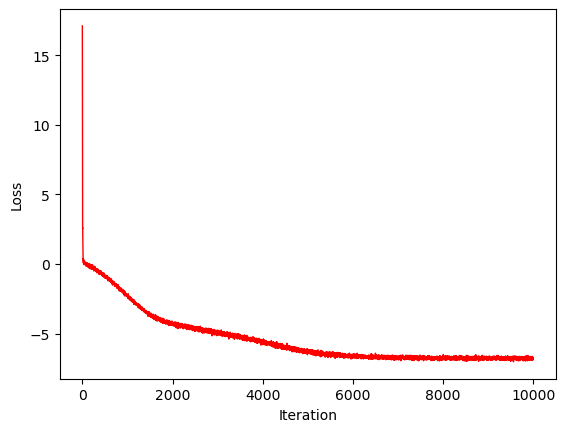

In [70]:
plt.plot(losses, lw=1, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")


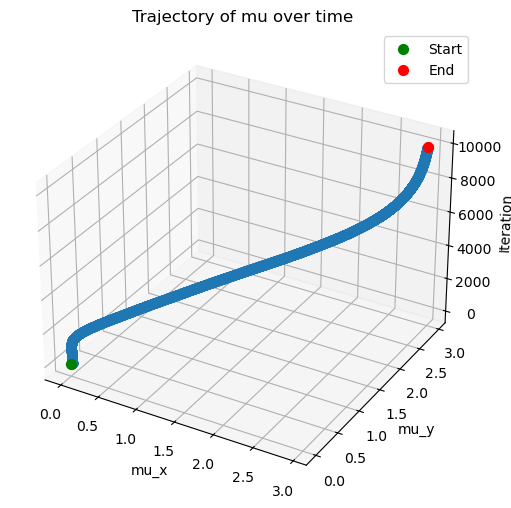

In [71]:
# Separate x and y coordinates
x = [point[0] for point in mu_traj]
y = [point[1] for point in mu_traj]
z = list(range(1, len(mu_traj)+1))  # Iterations 1 to 150

# Create 3D plot
fig = plt.figure(figsize=(6,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, marker='o', linestyle='-')

# Highlight start and end
ax.scatter(x[0], y[0], z[0], color='green', s=50, label='Start')
ax.scatter(x[-1], y[-1], z[-1], color='red', s=50, label='End')

ax.set_xlabel('mu_x')
ax.set_ylabel('mu_y')
ax.set_zlabel('Iteration')
ax.set_title('Trajectory of mu over time')
ax.legend()
plt.show()

Text(0, 0.5, 'Sigma')

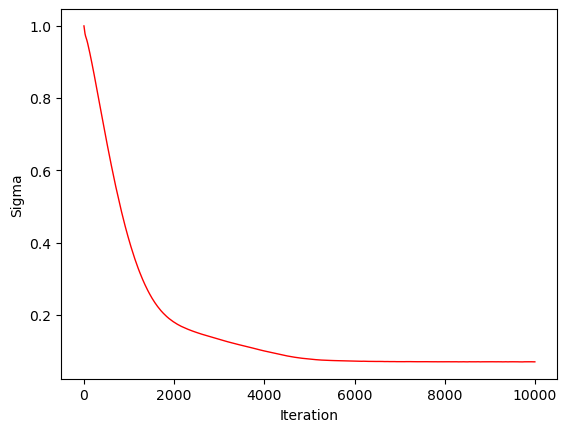

In [72]:
plt.plot(sigma_traj, lw=1, color='red')
plt.xlabel("Iteration")
plt.ylabel("Sigma")

In [73]:
N_steps = 100
batch_sz = 10_000
key, subkey = jax.random.split(key)
p_control, p_interpolation = params_history[-1]
sde_traj = integrate(p_control, p_interpolation, N_steps, batch_sz, subkey)

print(jnp.array(sde_traj["x"][-1]))

[[3.6757143 3.4101048]
 [2.9599438 2.598985 ]
 [2.2161233 2.13059  ]
 ...
 [3.5670729 3.7361012]
 [3.0832171 3.0427105]
 [3.646346  3.1455698]]


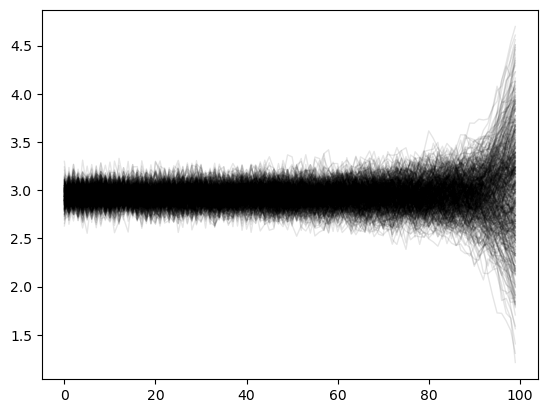

In [74]:
particle_index = 2
for i in range(5_00):
    plt.plot(sde_traj["x"][:,i,0], color="black", lw=1, alpha=0.1)

Text(0, 0.5, 'y')

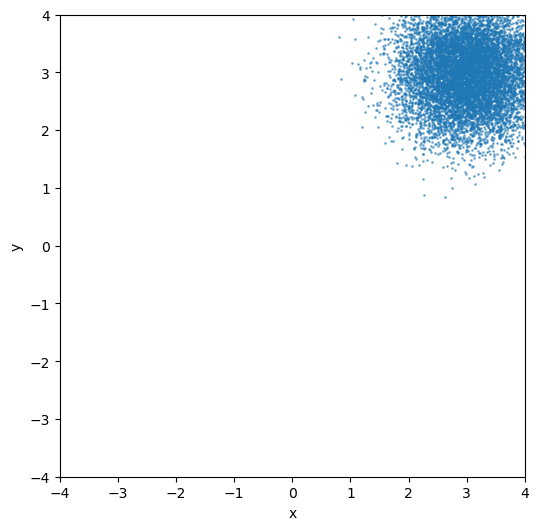

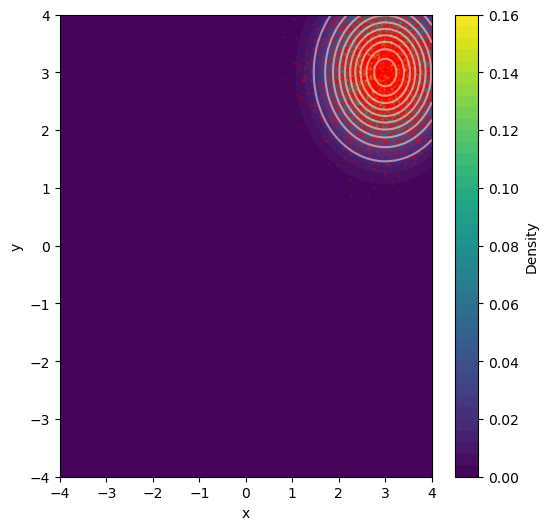

In [75]:
final_samples = sde_traj["x"][-1]

# do scatter plot of the final samples
plt.figure(figsize=(6,6))
plt.scatter(final_samples[:,0], final_samples[:,1], s=1, alpha=0.5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")

# 2d plot of log_target_batch
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-4, 4, 100)
X, Y = jnp.meshgrid(x, y)
Z = jnp.exp(log_target_batch(jnp.stack([X.ravel(), Y.ravel()], axis=-1))).reshape(X.shape)
plt.figure(figsize=(6,6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel("x")
plt.ylabel("y")

# add level lines
plt.contour(X, Y, Z, levels=10, colors='white', alpha=0.5)


plt.scatter(final_samples[:,0], final_samples[:,1], s=1, alpha=0.2, color='red')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")

